# Motivation

The role of this notebook is to explore the biological significance of the selected tf

In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio


import multiprocess as mp


# own libraries
SCRIPT_DIR = os.path.dirname(os.path.abspath("pcgna_processing.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))
sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import clustering as cs
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot, survival_comp
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import scatter_plot as sp
sys.path.append(os.path.dirname("../../src"))
# Gsea libraries

pio.templates.default = "ggplot2"


pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"
exp_folder_tumour = "network_I/tum/" # "/integration_v2.1/ - path from iNET
exp_folder_h42_ctrl = "network_I/healthyControls/"
dea_path = f'{data_base}/non_cancerous/dea/'


figures_path = "selective_edge_pruning/sel_tfs/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

tum_tpms = pd.read_csv(f"{data_base}/tumour/TPMs_selected_genes_v3_13k_gc42.tsv", sep="\t", index_col="genes")
tum_tpms_v4 = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

# Healthy and metadata
healthy_metadata = pd.read_csv(f"{data_base}/non_cancerous/healthy_bladder_metadata.tsv", sep="\t",index_col="Sample").drop(index=["Y2796_P0"])
healthy_metadata["sample_prcsd"] = healthy_metadata.index.str.replace("-", "_")

healthy_tpm = pd.read_csv(f"{data_base}/non_cancerous/healthy_data_all_gc42_v4.tsv", sep="\t", index_col="gene")
remap_col = {}
for col in healthy_tpm.columns:
    remap_col[col] = col.replace("-", "_")
healthy_tpm = healthy_tpm.rename(columns=remap_col)

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Analysis

In [3]:
def mean_var_bar(df: pd.DataFrame, markers: list):
    df.sort_values(by='tum_mean_expression', ascending=False, inplace=True)
    fig1 = px.bar(df, y='tum_mean_expression', error_y='tum_std_expression', title='Tum expression and variance')
    fig2 = px.bar(df, y='healthy_mean_expression', error_y='healthy_std_expression', title='Healthy expression and variance')

    num_cols=1
    subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.25,
    "v_spacing": 0.17,
    "main_title": "Mean expression (log) and variance",
    "height": 700,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
    }

    # Color based on high variance
    marker_colors_h = []
    marker_colors_t = []
    for gene, row in df.iterrows():
        if row['varied_label'] == 'tum':
            marker_colors_t.append("#F8766D") #reddish
            marker_colors_h.append('#619CFF') #bluesh
        elif row['varied_label'] == 'h':
            marker_colors_h.append("#F8766D") #reddish
            marker_colors_t.append('#619CFF') #bluesh
        elif row['varied_label'] == 'both':
            marker_colors_t.append("#D7B740") #greenish
            marker_colors_h.append("#D7B740") #greenish
        else:
            marker_colors_t.append('#619CFF') #bluesh
            marker_colors_h.append('#619CFF') #bluesh


    fig1.update_traces(marker_color=marker_colors_t)
    fig2.update_traces(marker_color=marker_colors_h)

    figs = [fig1, fig2]
    titles = [None, None]
    fig = gh.helper_multiplots(figs, titles, subplots_config)
    fig.update_yaxes(type='log', title='Tumour', row=1, col=1)
    fig.update_yaxes(type='log', title='Non-cancerous', row=2, col=1)


    for gene in markers:
        data = df.loc[gene]
        if gene in ['KLF4', 'ZBTB7C', 'GRHL3']:
            fig.add_annotation(text=f'{gene}', x=gene, y=np.log10(data['tum_mean_expression']), showarrow=True,
                                arrowhead=1, xref=f"x{1}", yref=f"y{1}", font=dict(color=px.colors.qualitative.Plotly[0]),  ax=-30, ay=-70)
        else:
            fig.add_annotation(text=f'{gene}', x=gene, y=np.log10(data['tum_mean_expression']), showarrow=True,
                                arrowhead=1, xref=f"x{1}", yref=f"y{1}", font=dict(color=px.colors.qualitative.Plotly[0]),  ax=-60, ay=-70)
                                
        fig.add_annotation(text=f'{gene}', x=gene, y=np.log10(data['healthy_mean_expression']), showarrow=True,
                            arrowhead=1, xref=f"x{2}", yref=f"y{2}", font=dict(color=px.colors.qualitative.Plotly[0]),  ax=-20, ay=-120)

    return fig

In [4]:
sel_tfs = pd.read_csv(f'{data_base}/tf_ctrl.csv', index_col='gene')
sel_tfs['tum_mean_expression'] = tum_tpms_v4.loc[sel_tfs.index].mean(axis=1)
sel_tfs['tum_median_expression'] = tum_tpms_v4.loc[sel_tfs.index].median(axis=1)
sel_tfs['tum_std_expression'] = tum_tpms_v4.loc[sel_tfs.index].std(axis=1)
sel_tfs['tum_var_expression'] = tum_tpms_v4.loc[sel_tfs.index].var(axis=1)

# sel_tfs.to_csv(f"{figures_path}/selected_tfs.tsv", sep='\t')

In [5]:
# sel_tfs = sel_tfs[~sel_tfs.index.isin(["ELF3", "JUNB"])]
dmy_df = sel_tfs.copy(deep=True)
dmy_df['tum_mean_expression'] = sel_tfs['tum_mean_expression'] +1
dmy_df['healthy_mean_expression'] = sel_tfs['healthy_mean_expression'] +1

log = True
fig = px.scatter(
    dmy_df.reset_index(),
    x="tum_mean_expression",
    y="healthy_mean_expression",
    # text="gene",
    color="mut_count",
    size="mut_count",
    hover_data="gene",
    color_continuous_scale=px.colors.sequential.Sunset_r,
    height=700,
    log_x=log,
    log_y=log,
    title=f'Selected TFs ({dmy_df.shape[0]})',
    # trendline='ols',  trendline_options=dict(log_x=True, log_y=True),
)

# Get the top 10 genes with highest healthy median expression
top_genes_h = dmy_df.nlargest(10, "healthy_median_expression").index.tolist()
top_genes_t = dmy_df.nlargest(10, "tum_median_expression").index.tolist()
top_genes_m = dmy_df.nlargest(10, "mut_count").index.tolist()

top_genes = list(set(top_genes_h + top_genes_t + top_genes_m))
top_genes.extend(["FOSL1", "FOXQ1", "MYCL", "STAT2", "IRF7", "MBD6", "ZNF750", "ZNF513", "BNC1", 'KLF6', 'HOXB6', "ZBTB7C", "KLF4", 'ZBTB10', 'RUNX1'])
top_genes = list(set(top_genes) - set(['ZNF750', 'IRF6', 'IRF7', 'TGIF1', "DOT1L"]))
inverted  = ['SPEN', 'ELF3', 'ZNF513']

# Add text annotation for the top 10 genes
for idx, gene in enumerate(top_genes):
    x = dmy_df.loc[dmy_df.index == gene, "tum_mean_expression"].values[0]
    y = dmy_df.loc[dmy_df.index == gene, "healthy_mean_expression"].values[0]
    ay = -30

    xanchor = 'right' if idx % 2 == 0 else 'left'
    ax = 10 if idx % 2 == 0 else 15

    ay = 30 if gene in inverted else -15

    if log:
        x, y = np.log10(x), np.log10(y)

    fig.add_annotation(x=x, y=y, text=gene, showarrow=True, arrowhead=1, ax=ax, ay=ay, xanchor=xanchor)

fig.update_layout(height=900, yaxis_title='Non-cancerous TPM', xaxis_title='Tum TPM_mean', 
                #   paper_bgcolor="rgba(0,0,0,0)",
                  xaxis=dict(tickfont=dict(size=16)),
                  yaxis=dict(tickfont=dict(size=16),),
                  font=dict(size=14),
                  title = ''
                  )
# fig.add_scatter(x=[0.1, 1500], y=[0.1, 1500], mode='lines+markers', name='')
save_fig(name="sel_tfs_mean_tum_healthy", fig=fig, base_path=figures_path, width=1400, height=700)
# fig.show()


In [6]:
# markers = ['BNC1', "AHR", 'OVOL1', "HES2", ]
high_varied_tum = ['EGR1', 'FOXQ1', "ATF3", 'MYCL', 'TP63', 'BHLHE41', 'FOSL1', 'OVOL1', 'MSX2', "ZNF750", "ZNF552", 'JRK', "HOXB6", "HES2", "EBF4", "REL", "BNC1", "NR4A2", 'KLF4', 'ZBTB7C', 'GRHL3']
high_varied_h = ['JUN', 'ETS2', 'KLF6', "ATF3", 'FOSL1', "EGR1", 'MAFF', "OVOL1", 'MAFK', 'ZNF750', 'HES2', "EBF4",'ARID5B', 'NR4A2', 'KLF4', 'BNC1', 'FOXQ1', 'ZBTB7C', 'ZBTB10', 'MYCL']
cmn_varied = ['OVOL1', 'FOSL1', 'KLF4', 'BNC1', 'MYCL', 'NR4A2', 'ZBTB7C',  'FOXQ1', 'ZNF750', 'EGR1', 'HES2', 'ATF3', 'EBF4']
cmn_varied = list(set(high_varied_h) & set(high_varied_tum))
only_tum = list(set(high_varied_tum) - set(cmn_varied))
only_h  = list(set(high_varied_h) - set(cmn_varied))

sel_tfs['varied_label'] = ''
sel_tfs.loc[high_varied_tum, 'varied_label'] = "tum"
sel_tfs.loc[high_varied_h, 'varied_label'] = "h"
sel_tfs.loc[cmn_varied, 'varied_label'] = "both"

markers = ["GRHL3", 'OVOL1', 'JRK', 'HES2', 'EBF4', 'NR4A2', 'KLF4', 'ZBTB7C', 'KLF6', 'ETS2']
fig = mean_var_bar(sel_tfs, markers=markers)
fig.update_layout(height=900,
                #   paper_bgcolor="rgba(0,0,0,0)",
                  xaxis=dict(tickfont=dict(size=16)),
                  yaxis=dict(tickfont=dict(size=16)),
                  font=dict(size=14),
                  title = ''
                  )
save_fig(name="sel_tfs_var_tum_healthy", fig=fig, base_path=figures_path, width=1600, height=900)
# fig.show()
del fig


## Comparing with known markers

In [10]:
luminal_markers = ["KRT20", "PPARG", "FOXA1", "GATA3", "SNX31", "UPK1A", "UPK2", "FGFR3"]
basal_markers = ["CD44", "KRT6A", "KRT5", "KRT14", "COL17A1"]
squamos_markers = ["DSC3", "GSDMC", "TCGM1", "PI3", "TP63"]
immune_markers = ["CD274", "PDCD1LG2", "IDO1", "CXCL11", "L1CAM", "SAA1"]
neural_diff = ["MSI1", "PLEKHG4B", "GNG4", "PEG10", "RND2", "APLP1", "SOX2", "TUBB2B"]

# TCGA markers - main paper
emt_claudin = ["ZEB1", "ZEB2", "SNAI1", "TWIST1", "CDH2", "CLDN3", "CLDN4", "CLDN7"]
ecm_muscle = ["PGM5", "DES", "C7", "SFRP4", "COMP", "SGCD"]

tcga_markers = luminal_markers + basal_markers + squamos_markers + immune_markers + neural_diff + emt_claudin + ecm_muscle

In [11]:
set(sel_tfs.index) & set(tcga_markers)

{'TP63'}

### Urothelium type markers

In [12]:
tf_diff = ["P63", "FOXA1","PPARG", "RARG", "IRF1", "ELF3", "GRHL3", "KLF5", "GATA4", "GATA6", "GATA3"]
krt = ["KRT13", "KRT14", "KRT15", "KRT20"]
upk = ["UPK1B", "UPK1A", "UPK3A", "UPK2"]
cld = ["CLDN3", "CLDN4", "CLDN5" ]

egfr_fam = ["EGFR", "ERBB2", "ERBB3", "ERBB4", "EGF", "AREG", "HBEGF","TGFA","BTC", "EREG"]
fgfr_fam = ["FGFR1", "FGFR2", "FGFR3", "FGF1", "FGF2"]
map_kpathway = ["RAS", "RAF", "MEK1", "MEK2", "MEK3", "MEK4","ERK"]
pi3_kpathway = ["PIK3C3", "PIK3R2", "PIK3C2B", "AKT1", "AKT2"]
others = ["MKI67", "MCM2", "UPK3A", "ZO1", "TJP1", "ZO2", "TJP2", "ZO3", "TJP3"]
hox_ur = ["HOXB2", "HOXB3", "HOXB5", "HOXB6", "HOXB8"]
hox_bla = ["HOXA9", "HOXA10", "HOXA11", "HOXA13"]

diff_markers = tf_diff + cld + krt + upk

uro_markers = diff_markers + egfr_fam + fgfr_fam + map_kpathway + pi3_kpathway + others + hox_ur + hox_bla

In [13]:
set(sel_tfs.index) & set(uro_markers)

{'ELF3', 'GRHL3', 'HOXB6', 'KLF5'}

### Lund type markers

In [14]:
lund_qtc1 = ["FLI1", "FOXP3", "ILKZF1", "IRF4", "IRF8", "RUNX3", "SCML4", "SPI1", "STAT4", "TBX21", "TFEC"]
lund_qtc2 = ["AEBP1", "BNC2", "GLI2", "GLIS1", "HIC1", "MSC", "PPRX1", "PPRX2", "TGFB1I1", "TWIST1"]
lund_qtc3 = ["EBF1", "HEYL", "LEF1", "MEF2C", "TCF4", "ZEB1", "ZEB2"]
lund_qtc8 = ["GATA5", "HAND1", "HAND2", "KLF16"]
lund_qtc17 = ["ARID5A", "BATF3", "VENTX"]
lund_ba_mes = lund_qtc1 + lund_qtc2 + lund_qtc3 + lund_qtc8 + lund_qtc17

lund_ba_sq = ["BRIP1", "E2F7", "FOXM1", "ZNF367", "IRF1", "SP110", "STAT1"]
lund_mes = ["TP53", "RB1", "FGFR3", "ANKHD1", "VIM", "ZEB2"]
ba_sq_inf = ["CDH3", "EGFR"]

lund_sc_ne = ["CHGA", "SYP", "ENO2", "EPCAM"] #Highly expressed

lund_markers = lund_ba_mes + lund_ba_sq + lund_mes + ba_sq_inf + lund_sc_ne

In [15]:
set(sel_tfs.index) & set(lund_markers)

{'KLF16', 'SP110', 'STAT1'}

### Immune markers

In [16]:
b_cells = ["BCL2", "BCL6", "CD19", "CD1D", "CD22", "CD24", "CD27", "CD274","CD34", "CD38", "CD40","CD44","CD5","CD53","CD69","CD72", "CD79A", "CD79B", "CD80", "CD86", "CD93", "CR2", "CXCR4", 'CXCR5',"FAS","FCER2", "FCRL4" "HAVCR1","IL10", 'IL2RA','IL7R','IRF4','ITGAX', 'LILRB1','MME','MS4A1','NT5E','PDCD1LG2','PRDM1','PTPRC','SDC1','SPN','TFRC','TLR9','TNFRSF13B','TNFRSF13C','TNFRSF17','XBP1']
t_cells = ['CD4', 'CD8', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR10', 'CD127', 'CD27', 'CD28', 'CD38', 'CD58', 'CD69', 'CTLA4', 'CXCR3', 'FAS', 'IL2RA',
        'IL2RB', 'ITGAE', 'ITGAL', 'KLRB1', 'NCAM1', 'PECAM1', 'PTGDR2', 'SELL', 'IFNG', 'IL10', 'IL13', 'IL17A', 'IL2', 'IL21','IL22', 'IL25', 'IL26', 'IL4', 'IL5', 'IL9', 'TGFB1', 'TNF', 'AHR', 'EOMES','FOXO4', 'FOXP1', 'FOXP3', 'GATA3','IRF4', 'LEF1', 'PRDM1', 'RORC','STAT4', 'TBX21','TCF7', 'GZMA']

nk_cells = ['B3GAT1','CCR7','CD16','CD2','CD226','CD244','CD27','CD300A','CD34','CD58','CD59','CD69','CSF2','CX3CR1','CXCR1','CXCR3','CXCR4','EOMES','GZMB','ICAM1','IFNG','IL1R1','IL22','IL2RB','IL7R','ITGA1','Itga2','ITGAL','ITGAM','ITGB2','KIR2DL1','KIR2DL2','KIT','Klrb1c','KLRC1','KLRC2','KLRD1','KLRF1','KLRG1','KLRK1','LILRB1','Klra4','Klra8','NCAM1','NCR1','NCR2','NCR3','PRF1','SELL','SIGLEC7','SLAMF6','SPN','TBX21','TNF']

macrophages_cells = [ 'ADGRE1','CCR2','CD14','CD68','CSF1R','Ly6c1','MARCO','MRC1','NOS2','PPARG','SIGLEC1','TLR2','ARG1','CD163','CD200R1','CD80','CD86','CLEC10A','CLEC7A','CSF2','CX3CR1','FCGR1A','ITGAM','MERTK','PDCD1LG2','Retnla','TNF','CCL22','CD36','CD40','IL10','IL1B','IL6','LGALS3','TLR4','CCL2','CCR5','CD209','CD63','CD86','CSF1','CXCL2','FCGR3A','IFNG','IL4','IRF4','ITGAX','MSR1','PDGFB','PTPRC','STAT6','TIMD4','Chil3','CLEC6A','IL1R1','ITGB2','PDCD1LG2','TLR7']

monocyte_cells = ['CD14','CD16','CSF1R','CX3CR1','ITGAM','ITGAX','LY6C1','CCR2','CXCR4','FCGR1A','SELL','SPN','ADGRE1','CCR7','TNF','CD86','IL10','IL1B','MERTK','TREML4','CD209','NR4A1','Ly6a','PTPRC','IL3RA','CD27','CCR5','CD32','CD1A','MRC1','ITGB3','CD9','CXCR6','CCR1','FLT3','KLF2','CLEC12A','CCR6','CCR8','CD68','CLEC7A','KIT','MAF','MAFB','SPI1','CD1C','PPARG','CEBPB','ITGAE','TEK']


immune_markers = b_cells + t_cells + nk_cells + macrophages_cells + monocyte_cells

In [17]:
set(sel_tfs.index) & set(immune_markers)

{'AHR', 'BCL6'}

# Morpheus

## Prepare for Morpheus
Outliers for standard log2 TPMS and norm of log, after applying agglomerative clustering with 1-pearson correlation.

```Python
outliers_log2 = ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']
```

```Python
norm_outliers = ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']
```

<!-- ![alt text](selective_edge_pruning/sel_tf_log2.png)
![alt text](selective_edge_pruning/sel_tf_norm_log2.png) -->



In [18]:
outliers_log2 = ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']

norm_outliers = ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']

cmn_outliars = set(outliers_log2) & set(norm_outliers)

print(f"### Num outliers for standard log2 {len(outliers_log2)}.\n --> {outliers_log2}")
print(f"### Num outliers for norm log2 {len(norm_outliers)}.\n --> {norm_outliers}")
print(f"### Common outliers *{len(cmn_outliars)}*.\n --> {cmn_outliars}")

### Num outliers for standard log2 14.
 --> ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']
### Num outliers for norm log2 12.
 --> ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']
### Common outliers *11*.
 --> {'TCGA-XF-A9ST', 'TCGA-BT-A2LA', 'TCGA-XF-A9T2', 'TCGA-FJ-A871', 'TCGA-XF-AAN7', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-DK-AA6T', 'TCGA-XF-AAMH', 'TCGA-BL-A3JM', 'TCGA-G2-A2EL'}


In [19]:
dmy_df = tum_tpms_v4.loc[sel_tfs.index]
dmy_df = np.log2(dmy_df + 1)

sel_metadata = ['KMeans_labels_6', 'consensus', 'TCGA408_classifier', 'Lund2017.subtype', 'ESTIMATE_score', "Immune_score", "Stromal_score", 'tumor_stage']
dmy_df = pd.concat([vu_output[sel_metadata].T, dmy_df], axis=0).dropna(axis=1)

# Remove outliers
dmy_df = dmy_df[list(set(dmy_df.columns) - set(cmn_outliars))]

# Adding notes on the genes
dmy_df['Notes'] = ''
dmy_df.loc[dmy_df.index.isin(lund_markers), "Notes"] = 'Lund marker'
dmy_df.loc[dmy_df.index.isin(immune_markers), "Notes"] = 'Immune marker'
dmy_df.loc[dmy_df.index.isin(uro_markers), "Notes"] = 'Uro markers'
dmy_df.loc[dmy_df.index.isin(tcga_markers), "Notes"] = 'TCGA markers'

dmy_df = dmy_df[['Notes'] + list(dmy_df.columns[:-1])]
dmy_df.to_csv(f"{figures_path}/log2_sel_tfs_no_outliers.tsv", sep='\t')

/var/folders/wd/10ylrkx55m78njljcl21yt2c0000gn/T/ipykernel_8699/557840676.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



## Importing Morpheus

In [20]:
morpheus_path = "selective_edge_pruning/morpheus/"

morp_df = pd.read_csv(f"{morpheus_path}/15_CS_norm_log2_sel_tfs_no_outliers.gct", sep="\t", skiprows=2)
columns = morp_df["id"]
morp_df = morp_df.drop(columns=["Notes"]).transpose()
morp_df.columns = columns
morp_df = morp_df.iloc[2:, :]

morp_df['dendrogram_cut'] = morp_df['dendrogram_cut'].astype(float).astype(str)

keep_clusters = []
# Size of 1%
size_th = round(morp_df.shape[0] * 0.01)
for cluster, size in morp_df['dendrogram_cut'].value_counts().items():
    if size > 5:
        keep_clusters.append(cluster)

# Drop clusters that are smaller than 1% of the cohort size
morp_df = morp_df.loc[morp_df['dendrogram_cut'].isin(keep_clusters)]
morp_df.shape

(378, 107)

In [21]:
#Sankey
morp_df.rename_axis("sample", axis="columns", inplace=True)
reorder_cols = [
    "TCGA408_classifier",
    "dendrogram_cut",
    # "KMeans_labels_6",
    'Lund2017.subtype',
    # "consensus",
]
meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols, title='MIBC stratification based on the TF from selective edge pruning', retMeta=True)
sky_fig.update_layout(
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    font=dict(size=16),
    paper_bgcolor="rgba(0,0,0,0)",
)
# sky_fig.show()
save_fig(name="sankey_sel_tfs", fig=sky_fig, base_path=figures_path, width=1200, height=600)
del sky_fig

## Dumbell plots

In [22]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# Main function to see the differences
def dumbell_plots(morp_df: pd.DataFrame, tum_df: pd.DataFrame, sel_tfs: pd.DataFrame, cls_1="", cls_2="", markers=[], log=False):

    cluster_1, cluster_2 = int(cls_1.split("_")[-1]), int(cls_2.split("_")[-1])

    samples_1 = morp_df[morp_df['dendrogram_cut'] == cluster_1].index
    samples_2 = morp_df[morp_df['dendrogram_cut'] == cluster_2].index

    # Reconstruct the TPM
    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_1 = dmy_df[samples_1]
    df_1[cls_1] = df_1.mean(axis=1)

    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_2 = dmy_df[samples_2]
    df_2[cls_2] = df_2.mean(axis=1)

    comb_df = pd.concat([df_1[cls_1], df_2[cls_2]], axis=1)

    # Prepare for plotting
    plot_data = {"line_x": [], "line_y": [], cls_1: [], cls_2: []}

    y_axis_title = 'TPM mean'
    if log:
        comb_df[cls_1] = np.log2(comb_df[cls_1] + 1)
        comb_df[cls_2] = np.log2(comb_df[cls_2] + 1)
        y_axis_title = 'Log2(TPM + 1) mean '

    comb_df['diff']= np.abs(comb_df[cls_1] - comb_df[cls_2])
    comb_df.sort_values(by='diff', ascending=False, inplace=True)

    genes = list(comb_df.index)

    # generate the data for plots
    for gene, row in comb_df.iterrows():
        # print(gene)

        val_1, val_2 = row[cls_1], row[cls_2]
        # The data for two scatter points cls_1 and cls_2
        plot_data[cls_1].extend([val_1])
        plot_data[cls_2].extend([val_2])
        # The line between the two clases
        plot_data["line_y"].extend([
                val_1,
                val_2,
                None,
            ]
        )
        plot_data["line_x"].extend([gene, gene, None])

    # plotting
    fig = go.Figure(
    data=[
        go.Scatter(
            x=plot_data["line_x"],
            y=plot_data["line_y"],
            mode="lines",
            showlegend=False,
            marker=dict(
                color="grey"
            )
        ),
        go.Scatter(
            y=plot_data[cls_1],
            x=genes,
            mode="markers",
            name=cls_1,
            marker=dict(
                # color="green",
                size=10
            )
            
        ),
        go.Scatter(
            y=plot_data[cls_2],
            x=genes,
            mode="markers",
            name=cls_2,
            marker=dict(
                # color="blue",
                size=10
            )   
        ),
        ]
    )

    # Add title and change the figure size
    fig.update_layout(
        title=f"Changes between {cls_1} and {cls_2}",
        yaxis_title=y_axis_title,
        xaxis_title="Gene",
        legend_itemclick=False
    )

    fig.update_xaxes()
    # Add markers

    annotations = []
    for i, marker in enumerate(markers):
        sel_df = comb_df.loc[marker][[cls_1, cls_2]]
        x = marker
        # avoid overlapping
        xanchor = 'right' if i % 2 == 0 else 'left'
        ax = -10 if i % 2 == 0 else 10
        y = sel_df.max() if i % 2 == 0 else sel_df.min()
        ay = -10 if i % 2 == 0 else 50

        fig.add_annotation(
                x=x,
                y=y,
                text=marker,
                showarrow=True,
                ax = ax,  # No horizontal offset
                ay=ay,
                xanchor=xanchor
            )
        annotations.append({
                "x": x,
                "y": y,
                "text": marker,
                "showarrow": True,
                "ax": ax,  
                "ay": ay,
                "xanchor": xanchor, 
            })
        
    return fig, comb_df, annotations

In [23]:
cluster_1, label_1 = 3, 'mesLike'
cluster_2, label_2 = 5, 'smallBasal'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = [ 'TP63','HES2', "GRHL3", 'BNC1', 'IRF6', 'ZNF750', 'OVOL1', 'KLF5', "ETS2", "AHR", 'STAT1', "ZBTB7C"]

morp_df['dendrogram_cut'] = morp_df['dendrogram_cut'].astype(float).astype(int)
fig5, df, ann5 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title5= f'{cls_1} vs {cls_2}'
fig5

In [24]:
# Basal large vs Luminal
log = True
cluster_1, label_1 = 13, 'luminal'
cluster_2, label_2 = 4, 'basal'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = ['JRK','HES2', 'BNC1', 'ELF3', 'FOSL1', 'MYCL', 'FOXQ1', "GRHL3", 'STAT1', 'HOXB6', 'TP63']

fig1, df, ann1 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title1 = f'A) {cls_1} vs {cls_2}'

# Lum vs LumInf
cluster_1, label_1 = 13, 'luminal'
cluster_2, label_2 = 12, 'lumInf'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = ['TP63', 'MECOM', "IRF6", 'KLF6', 'IRF7', 'ELF3', 'BNC1']

fig2, df, ann2 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title2= f'B) {cls_1} vs {cls_2}'

# Small vs LumInf
cluster_1, label_1 = 5, 'smallBasal'
cluster_2, label_2 = 12, 'lumInf'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = ['TP63',  'MYCL', 'BNC1', "GRHL3",'HES2',  'MSX2', 'IRF6', 'HOXB6']

fig3, df, ann3 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title3 = f'C) {cls_1} vs {cls_2}'

# Mes-like vs Basal
cluster_1, label_1 = 3, 'mesLike'
cluster_2, label_2 = 4, 'basal'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = ["GRHL3",'BNC1', 'ELF3', 'MYCL','HES2', 'TP63', 'IRF6', 'STAT1', 'ZBTB7C', 'ZNF750', 'JUNB']

fig4, df, ann4 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title4 = f'D) {cls_1} vs {cls_2}'

#Mes-like vs small basal
cluster_1, label_1 = 3, 'mesLike'
cluster_2, label_2 = 5, 'smallBasal'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = [ 'TP63','HES2', "GRHL3", 'BNC1', 'IRF6', 'ZNF750', 'OVOL1', 'KLF5', "ETS2", "AHR", 'STAT1', "ZBTB7C", 'ELF3', "REL", "IRF7"]

fig5, df, ann5 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title5= f'E) {cls_1} vs {cls_2}'


# Small basal vs Basla
cluster_1, label_1 = 4, 'basal'
cluster_2, label_2 = 5, 'smallBasal'
cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
markers = ['ZBTB7C', 'MECOM', "TP63", 'ELF3', 'KLF5', 'MSX2',]

fig6, df, ann6 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title6 = f'F) {cls_1} vs {cls_2}'

In [25]:
num_cols=2
subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.04,
    "v_spacing": 0.1,
    "main_title": "Gene differences",
    "height": 1800,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
}

figs, titles = [fig1, fig2, fig3, fig4, fig5, fig6], [title1, title2, title3, title4, title5, title6]
annotations = [ann1, ann2, ann3, ann4, ann5, ann6]
# annotations = []

# Defining the trace colors
traces_names = ["mesLike_3", 'basal_4', "luminal_13", 'lumInf_12', "smallBasal_5"]
trace_colors = {}
for idx, name in enumerate(traces_names):
     trace_colors[name] = px.colors.qualitative.Plotly[idx]

# Making sure that we only display the traces once
displayed_legends = set()
for fig in figs:
    for trace in fig.data:
        if trace.name:
            trace.update(marker=dict(color=trace_colors[trace.name]))

            # Manage legend entries
            if trace.name not in displayed_legends:
                displayed_legends.add(trace.name)
                trace.showlegend = True  # Show legend for this trace
            else:
                trace.showlegend = False  # Hide legend for this trace

fig = gh.helper_multiplots(figs, titles, subplots_config)

# Adding the annotations to the subtplots
idx_row, idx_col = 1, 1

for i, ann in enumerate(annotations):
    for idx, elem in enumerate(ann):
        fig.add_annotation(elem, row=idx_row, col=idx_col)
    if idx_col % num_cols == 0:
            idx_col = 0
            idx_row += 1
    idx_col += 1

fig.update_layout(height=2100, yaxis_title='log2(TPM+1)',
                  showlegend=True,
                  legend=dict(
                       orientation="h",
                       title="Subtypes", 
                       yanchor="bottom",
                       y=1.0,
                       xanchor="center", 
                       x=0.5, 
                       bgcolor="rgba(0,0,0,0)",
                       font=dict(size=16, color="#003366"),
                    ),
                #   paper_bgcolor="rgba(0,0,0,0)",
                  xaxis=dict(tickfont=dict(size=16)),
                  yaxis=dict(tickfont=dict(size=16),),
                  font=dict(size=14),
                  title = '')
# fig.show()
del fig
# save_fig(name="dumbell_sel_tfs", fig=fig, base_path=figures_path, height=1700, width=2700)

### Single plot version

In [26]:
# Single scatter plot in plotly
def plot_cluster_means(morp_df: pd.DataFrame, tum_df: pd.DataFrame, sel_tfs: pd.DataFrame, cls_1="", cls_2="", markers=[], log=False):

    cluster_1, cluster_2 = int(cls_1.split("_")[-1]), int(cls_2.split("_")[-1])

    samples_1 = morp_df[morp_df['dendrogram_cut'] == cluster_1].index
    samples_2 = morp_df[morp_df['dendrogram_cut'] == cluster_2].index

    # Reconstruct the TPM
    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_1 = dmy_df[samples_1]
    df_1[cls_1] = df_1.mean(axis=1)

    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_2 = dmy_df[samples_2]
    df_2[cls_2] = df_2.mean(axis=1)

    comb_df = pd.concat([df_1[cls_1], df_2[cls_2]], axis=1)
    fig = px.scatter(comb_df.reset_index(), x=cls_1, y=cls_2, hover_data='genes', title=f'{cls_1} vs {cls_2}', log_x=log, log_y=log, trendline='ols', trendline_color_override='red', trendline_options=dict(log_x=log, log_y=log))

    for marker in markers:
        dmy = comb_df.loc[marker]
        x, y = dmy.values[0], dmy.values[1]
        if log:
            x, y = np.log10(x), np.log10(y)
            
        fig.add_annotation(
            x=x,
            y=y,
            text=dmy.name,
            showarrow=False,
            xanchor="right",
        )
    return fig, comb_df

# Matplotlib functions - useful for multiplots
def plot_cluster_means_2(ax, morp_df, tum_df, sel_tfs, cls_1="", cls_2="", markers=[], log=False):
    cluster_1 = int(cls_1.split("_")[-1])
    cluster_2 = int(cls_2.split("_")[-1])

    samples_1 = morp_df[morp_df['dendrogram_cut'] == cluster_1].index
    samples_2 = morp_df[morp_df['dendrogram_cut'] == cluster_2].index

    # Reconstruct the TPM
    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_1 = dmy_df.loc[:, samples_1].mean(axis=1).rename(cls_1)
    df_2 = dmy_df.loc[:, samples_2].mean(axis=1).rename(cls_2)

    comb_df = pd.concat([df_1, df_2], axis=1)

    # Plotting
    x_values = comb_df[cls_1]
    y_values = comb_df[cls_2]
    
    if log:
        x_values = np.log10(x_values + 1)  # +1 to handle log(0) cases
        y_values = np.log10(y_values + 1)
        xlabel = f'Log10({cls_1})'
        ylabel = f'Log10({cls_2})'
        title = f'Log10-scaled: {cls_1} vs {cls_2}'
    else:
        xlabel = cls_1
        ylabel = cls_2
        title = f'{cls_1} vs {cls_2}'

    ax.scatter(x_values, y_values)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Adding trend line
    z = np.polyfit(x_values, y_values, 1)  # Fit a first degree polynomial (linear fit)
    p = np.poly1d(z)  # Create the polynomial object to evaluate
    ax.plot(x_values, p(x_values), "r--")  # Plot the trend line

    # Annotations
    for marker in markers:
        x = x_values.get(marker, None)
        y = y_values.get(marker, None)
        if x is not None and y is not None:
            ax.annotate(marker, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Adding gridlines
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# save_fig(name="test", fig=fig, base_path=figures_path, width=1400, height=700)

In [27]:
if 0:
    cluster_1, label_1 = 9, 'basal'
    cluster_2, label_2 = 7, 'luminf'
    cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'

    markers = ['TP63', 'HES2', 'MSX2', "MYCL", 'ZSCAN16', 'MAFF', "IRF7", 'IRF6', 'KLF5', "ETS2"]

    dmy_df = sel_tfs.loc[~sel_tfs.index.isin(["BNC1"])]
    fig, df = plot_cluster_means(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=dmy_df, cls_1=cls_2, cls_2=cls_1, markers=markers, log=True)
    # fig.show()

### Matplotlib version

In [28]:
if 0:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    cluster_1, label_1 = 10, 'basal'
    cluster_2, label_2 = 13, 'basal'
    cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
    markers = ["IRF6", "TP63", "GRHL3", "HES2", 'BNC1', "REL", "ZBTB7C", "STAT1", "ELF3", "JUNB", "ZNF750", "AHR", "MYCL", 'REPIN1']
    fig1, df = plot_cluster_means_2(axs[0], morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)

    # Repeat for the second figure
    cluster_1, cluster_2, label_1, label_2 = 10, 9, 'basal', 'basal'
    cls_1, cls_2 = f'{label_1}_{cluster_1}', f'{label_2}_{cluster_2}'
    markers = ["MSX2", "ZBTB7C", "ELF3", "KLF5", "TP63", "MECOM", 'NR4A2']
    fig2, df = plot_cluster_means_2(axs[1], morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)


# Expression comparison

## Non-cancerous

In [9]:
def box_exp_groups(df: pd.DataFrame, genes: list, classifier='consensus', title='', height=1200):
    
    color_map = {}
    if classifier == 'consensus':
        color_map = {'LumP': "#00CC33", 'LumNS': "#006600",  'LumU': "#0033CC", 'Stroma-rich': "#99CC33",  "Ba/Sq": "#FF0000", 'NE-like': "#CC00FF"}
    figs, titles = [], []
    for gene in genes:
        fig = px.box(df, y=gene, x=classifier, points='all',  color=classifier, color_discrete_map=color_map)
        fig = fig.update_layout(title=gene, yaxis_title='TPM', xaxis_title=classifier, title_y=0.84)
        figs.append(fig)
        titles.append(gene)

    num_cols=3
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.04,
        "v_spacing": 0.05,
        "main_title": title,
        "height": height,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }
    fig = gh.helper_multiplots(figs, titles, subplots_config)

    return fig

In [7]:
if 0: 
    sel_tpms = healthy_tpm.loc[sel_tfs.index]
    sel_tpms = np.log2(sel_tpms + 1)
    height= 1200
    title = 'Cmn baried'

    classifier = 'NHU_differentiation'
    comb_df = pd.concat([sel_tpms.T, healthy_metadata[classifier]], axis=1).dropna()
    figs, titles = [], []
    for gene in cmn_varied:
        grouped= comb_df[[gene, classifier]].groupby(classifier)
        tst_df = pd.concat([grouped.mean().rename(columns={gene: 'mean'}), grouped.std().rename(columns={gene: 'std'})], axis=1).reset_index()
        fig = px.bar(tst_df, x=classifier, y='mean', error_y='std', color=classifier, barmode='group')
        fig = fig.update_layout(bargap=0.05) 

        figs.append(fig)
        titles.append(gene)

    num_cols=3
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.04,
        "v_spacing": 0.05,
        "main_title": title,
        "height": height,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }
    fig = gh.helper_multiplots(figs, titles, subplots_config)
    # fig.show()
    fig.update_layout(bargap=0.01)


In [10]:
sel_tpms = healthy_tpm.loc[sel_tfs.index]
sel_tpms = np.log2(sel_tpms + 1)

dmy_df = pd.concat([healthy_metadata.reset_index().set_index('sample_prcsd')[['Dataset', 'NHU_differentiation']], sel_tpms.T], axis=1).dropna()

fig = box_exp_groups(dmy_df, genes=cmn_varied, classifier='NHU_differentiation', height=1200, title='Expression across Diff status. Genes that are varied in both non-cancerous and tumours across')

height, width = 1200, 2000
save_fig(name="log2_tissueDiff_cmn_var", fig=fig, base_path=figures_path, width=width, height=height)

In [11]:
if 0:
    sel_tpms = healthy_tpm.loc[sel_tfs.index]
    sel_tpms = np.log2(sel_tpms + 1)

    dmy_df = pd.concat([healthy_metadata.reset_index().set_index('sample_prcsd')[['NHU_differentiation', 'Diagnosis']], sel_tpms.T], axis=1).dropna()

    fig = box_exp_groups(dmy_df, genes=high_varied_h, classifier='Diagnosis', height=1200, title='Expression across Diagnosis status. Genes that are varied healthy')

    height, width = 1200, 2000
    save_fig(name="log2_diagnosis_nonTum_var", fig=fig, base_path=figures_path, width=width, height=height)

## Tumour

In [36]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)
dmy_df = pd.concat([vu_output[['consensus', 'TCGA408_classifier', 'KMeans_labels_6', "ESTIMATE_score"]], sel_tpms ], axis=1).dropna()

height, width = 2400, 2000
height, width = 1200, 2000

fig = box_exp_groups(dmy_df, genes=cmn_varied, classifier='consensus', height=height, title='Expression across consensus. Genes that are core in Pi')
fig.show()
# save_fig(name="log2_coreBladder", fig=fig, base_path=figures_path, width=width, height=height)
# del fig

In [33]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
dmy_df = np.log2(sel_tpms.div(sel_tpms.mean()) + 1)


dmy_df = pd.concat([vu_output[['consensus', 'TCGA408_classifier', 'KMeans_labels_6', "ESTIMATE_score"]], dmy_df ], axis=1).dropna()

height, width = 2400, 2000
height, width = 1200, 2000

fig = box_exp_groups(dmy_df, genes=cmn_varied, classifier='consensus', height=height, title='Expression across consensus. Genes that are core in Pi')
fig.show()

gene              ELF3      JUNB      KLF5     STAT1     TGIF1  SLC2A4RG  \
TCGA-E7-A97P  0.968943  1.136001  1.023992  1.378865  0.998850  0.930957   
TCGA-XF-A9ST  0.731589  0.642284  0.696315  0.706674  0.957552  0.863211   
TCGA-CU-A0YR  1.173886  1.018664  1.020055  1.155831  1.076613  0.920850   
TCGA-XF-A8HB  1.169961  0.932610  1.009483  0.841312  0.993390  1.235361   
TCGA-GU-A42Q  1.002285  0.920603  1.036118  1.054972  0.908119  1.208316   
...                ...       ...       ...       ...       ...       ...   
TCGA-ZF-AA51  1.183144  1.040615  0.823154  1.014538  1.058630  0.984349   
TCGA-ZF-A9R3  1.183538  1.100790  1.104170  1.137632  0.985172  1.048536   
TCGA-DK-A6AV  1.065158  1.031538  1.143854  0.923658  1.095508  0.935608   
TCGA-FD-A6TA  1.202533  1.019543  1.126084  1.037189  1.025491  0.791277   
TCGA-XF-A9SV  1.153639  1.040467  1.055664  0.880510  1.038603  0.965479   

gene               JUN      ETS2      EGR1      IRF9  ...    ZNF609      KLF4  \
TCGA-E7-A97P  1.212826  1.128851  1.532152  1.176688  ...  1.039969  1.130293   
TCGA-XF-A9ST  0.544944  0.847628  0.604568  0.521191  ...  1.048574  0.492656   
TCGA-CU-A0YR  1.063522  0.895810  1.125504  1.000228  ...  1.119965  1.103615   
TCGA-XF-A8HB  0.958368  1.241812  0.869853  1.002505  ...  0.773781  1.510285   
TCGA-GU-A42Q  1.289307  1.219143  1.044109  0.859819  ...  1.228590  0.763772   
...                ...       ...       ...       ...  ...       ...       ...   
TCGA-ZF-AA51  1.288109  0.986605  0.896675  0.970874  ...  0.812100  1.303725   
TCGA-ZF-A9R3  0.939899  1.151589  1.216956  1.164798  ...  1.100491  0.425924   
TCGA-DK-A6AV  1.015213  0.881488  1.054406  0.842955  ...  1.119404  1.034604   
TCGA-FD-A6TA  1.083342  0.787957  1.113704  0.914174  ...  0.971923  0.695804   
TCGA-XF-A9SV  0.843123  0.891300  0.716508  1.033907  ...  1.055861  0.936954   

gene              LCOR    TRERF1       REL     NFAT5    ZBTB21    ZBTB10  \
TCGA-E7-A97P  0.824615  1.035960  0.659683  0.956897  0.753976  0.572143   
TCGA-XF-A9ST  0.948047  1.227678  0.336560  0.569025  0.932920  1.841946   
TCGA-CU-A0YR  1.365825  0.394414  1.125916  1.395764  0.917277  1.133553   
TCGA-XF-A8HB  0.897062  1.110538  0.391374  0.587500  1.088013  1.046707   
TCGA-GU-A42Q  0.938256  1.151075  1.377693  1.068070  1.322858  1.329145   
...                ...       ...       ...       ...       ...       ...   
TCGA-ZF-AA51  0.931595  0.468373  1.458567  1.360633  0.986743  1.109306   
TCGA-ZF-A9R3  1.270709  1.347560  1.694604  1.419887  1.144691  1.063968   
TCGA-DK-A6AV  1.422419  1.147485  1.369775  1.527239  0.888875  0.779978   
TCGA-FD-A6TA  1.039019  0.919363  1.291597  0.976058  0.832053  0.786268   
TCGA-XF-A9SV  1.030238  1.388663  0.914370  0.753434  0.886868  1.711045   

gene              BNC1      ZXDB  
TCGA-E7-A97P  4.797379  0.968315  
TCGA-XF-A9ST  0.051198  0.563038  
TCGA-CU-A0YR  0.196349  1.207780  
TCGA-XF-A8HB  0.006079  1.018226  
TCGA-GU-A42Q  5.546048  0.999324  
...                ...       ...  
TCGA-ZF-AA51  0.012604  0.947645  
TCGA-ZF-A9R3  0.000000  1.080976  
TCGA-DK-A6AV  0.000000  1.012424  
TCGA-FD-A6TA  0.000000  0.881542  
TCGA-XF-A9SV  0.000000  1.268011  

[404 rows x 98 columns]

In [50]:
sel_samples

Consensus_Lund Lund2017.subtype TCGA_Lund  RawKMeans_CS_4  \
Sample                                                                   
TCGA-BL-A3JM        NE_like       Sc/NE-like  Neuronal             2.0   
TCGA-BT-A2LA        NE_like       Sc/NE-like  Neuronal             2.0   
TCGA-C4-A0EZ        NE_like       Sc/NE-like  Neuronal             2.0   
TCGA-G2-A2EL        NE_like       Sc/NE-like  Neuronal             2.0   
TCGA-XF-AAN7        NE_like       Sc/NE-like  Neuronal             2.0   

              RawKMeans_CS_5  RawKMeans_CS_6  RawKMeans_CS_7  \
Sample                                                         
TCGA-BL-A3JM             4.0             5.0             6.0   
TCGA-BT-A2LA             4.0             5.0             6.0   
TCGA-C4-A0EZ             4.0             5.0             6.0   
TCGA-G2-A2EL             4.0             5.0             6.0   
TCGA-XF-AAN7             4.0             5.0             6.0   

             TCGA408_classifier consensus  SB_split  ...  2019CC_LumP  \
Sample                                               ...                
TCGA-BL-A3JM            NE-like   NE-like       3.0  ...     0.238822   
TCGA-BT-A2LA            NE-like   NE-like       3.0  ...     0.053785   
TCGA-C4-A0EZ            NE-like   NE-like       3.0  ...     0.123307   
TCGA-G2-A2EL            NE-like   NE-like       3.0  ...     0.058599   
TCGA-XF-AAN7            NE-like   NE-like       3.0  ...     0.186089   

              2019CC_LumNS  2019CC_LumU  2019CC_Stroma-rich  2019CC_Ba/Sq  \
Sample                                                                      
TCGA-BL-A3JM      0.248249     0.309334            0.369947      0.393021   
TCGA-BT-A2LA      0.081131     0.146024            0.188017      0.163166   
TCGA-C4-A0EZ      0.131887     0.178670            0.253057      0.314850   
TCGA-G2-A2EL      0.034539     0.111264            0.096133      0.207264   
TCGA-XF-AAN7      0.203256     0.257871            0.330148      0.309971   

              2019CC_NE-like  TCGA_2017_AM_remap  \
Sample                                             
TCGA-BL-A3JM        0.449765             NE-like   
TCGA-BT-A2LA        0.560947             NE-like   
TCGA-C4-A0EZ        0.589838             NE-like   
TCGA-G2-A2EL        0.509916             NE-like   
TCGA-XF-AAN7        0.426390             NE-like   

              InflammatoryInfiltrateResponseTSPresent  infiltration_score  \
Sample                                                                      
TCGA-BL-A3JM                     Lymphocytes, minimal                   3   
TCGA-BT-A2LA                                   Absent                   0   
TCGA-C4-A0EZ                 Lymphocytes, eosinophils                   6   
TCGA-G2-A2EL                                   Absent                   0   
TCGA-XF-AAN7                                   absent                   0   

              infiltration_label  
Sample                            
TCGA-BL-A3JM          Medium Inf  
TCGA-BT-A2LA              No Inf  
TCGA-C4-A0EZ            High Inf  
TCGA-G2-A2EL              No Inf  
TCGA-XF-AAN7              No Inf  

[5 rows x 53 columns]

gene              ELF3      JUNB      KLF5     STAT1     TGIF1  SLC2A4RG  \
TCGA-XF-A8HB  1.035051  0.905660  0.900920  0.944789  0.982059  1.239541   
TCGA-ZF-AA5N  0.763824  0.858142  0.565497  1.021231  0.848237  0.986227   
TCGA-KQ-A41R  1.152191  0.878184  0.940453  0.779990  1.032689  0.982056   
TCGA-H4-A2HQ  1.050149  1.021958  1.177438  1.336910  1.106609  0.971506   
TCGA-E7-A8O8  0.950008  0.988386  0.970109  0.802636  1.031586  0.896165   
...                ...       ...       ...       ...       ...       ...   
TCGA-G2-A2EL  1.182969  0.732871  1.386707  1.227114  1.009532  0.826671   
TCGA-BT-A2LA  0.264065  1.306282  0.519625  0.919754  0.817686  1.120423   
TCGA-XF-AAN7  0.071972  1.292964  0.972997  0.860579  1.075076  1.056308   
TCGA-BL-A3JM  1.678579  0.835642  1.655427  1.185712  1.100806  1.110979   
TCGA-C4-A0EZ  1.802415  0.832241  0.465244  0.806841  0.996900  0.885619   

gene               JUN      ETS2      EGR1      IRF9  ...    ZNF609      KLF4  \
TCGA-XF-A8HB  1.024079  1.212722  0.998049  1.022597  ...  0.771927  1.647938   
TCGA-ZF-AA5N  1.086269  0.966398  1.038936  0.902271  ...  0.750668  1.488246   
TCGA-KQ-A41R  0.663750  0.945851  1.171710  1.049779  ...  0.698566  0.915937   
TCGA-H4-A2HQ  1.198022  1.117876  1.256243  1.232531  ...  1.080682  1.246679   
TCGA-E7-A8O8  0.503012  0.725998  0.714070  0.988013  ...  0.816431  0.720296   
...                ...       ...       ...       ...  ...       ...       ...   
TCGA-G2-A2EL  0.858271  1.499731  0.681070  1.233677  ...  0.919385  0.813260   
TCGA-BT-A2LA  1.283629  0.878578  1.561982  0.970574  ...  1.041295  0.891947   
TCGA-XF-AAN7  1.080031  1.068525  1.247133  0.938539  ...  1.297864  0.276169   
TCGA-BL-A3JM  0.860391  0.758650  0.754722  1.036246  ...  0.998216  1.518190   
TCGA-C4-A0EZ  0.917679  0.794516  0.755092  0.820964  ...  0.743240  1.500433   

gene              LCOR    TRERF1       REL     NFAT5    ZBTB21    ZBTB10  \
TCGA-XF-A8HB  0.770532  0.948026  0.340810  0.520982  1.068753  0.929119   
TCGA-ZF-AA5N  0.497588  0.901277  0.306536  0.537627  0.742847  0.685417   
TCGA-KQ-A41R  0.982689  1.181692  1.285516  0.677017  0.946758  1.009919   
TCGA-H4-A2HQ  1.192948  1.211989  1.491302  1.707617  1.314506  1.446508   
TCGA-E7-A8O8  1.061189  0.880624  0.397425  0.444414  0.600909  0.675442   
...                ...       ...       ...       ...       ...       ...   
TCGA-G2-A2EL  1.419345  1.099965  1.324143  1.403605  1.258552  0.969898   
TCGA-BT-A2LA  0.760035  0.752656  1.093203  0.784204  1.112003  1.102312   
TCGA-XF-AAN7  0.759901  1.526964  0.617935  0.602896  0.751412  1.139720   
TCGA-BL-A3JM  1.040424  0.775192  1.291448  1.599212  0.901539  0.857831   
TCGA-C4-A0EZ  1.020294  0.845223  0.673271  0.610083  0.976493  0.930240   

gene              BNC1      ZXDB  
TCGA-XF-A8HB  0.049902  0.962042  
TCGA-ZF-AA5N  0.472600  0.506499  
TCGA-KQ-A41R  0.000000  0.568835  
TCGA-H4-A2HQ  0.000000  1.152281  
TCGA-E7-A8O8  0.463932  0.559302  
...                ...       ...  
TCGA-G2-A2EL  0.142906  1.162053  
TCGA-BT-A2LA  4.784327  1.007289  
TCGA-XF-AAN7  0.000000  1.151158  
TCGA-BL-A3JM  0.072768  0.854716  
TCGA-C4-A0EZ  0.000000  0.824783  

[404 rows x 98 columns]

In [61]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)

centred_tpms = pd.DataFrame()
for subtype in vu_output['consensus'].unique():
    sel_samples = vu_output.loc[vu_output['consensus'] == subtype].index
    sel_df = sel_tpms.loc[sel_tpms.index.isin(sel_samples)]

    sel_df = sel_df/sel_df.mean()

    centred_tpms = pd.concat([centred_tpms, sel_df], axis=0)


dmy_df = pd.concat([vu_output[['consensus', 'TCGA408_classifier', 'KMeans_labels_6', "ESTIMATE_score"]], centred_tpms ], axis=1).dropna()



height, width = 2400, 2000
height, width = 1200, 2000

fig = box_exp_groups(dmy_df, genes=cmn_varied, classifier='consensus', height=height, title='Expression across consensus. Genes that are core in Pi')
fig.show()

In [34]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)
dmy_df = pd.concat([morp_df[['consensus', 'dendrogram_cut']], sel_tpms ], axis=1).dropna()

dmy_df['dendrogram_label']=dmy_df['dendrogram_cut'].replace({3: 'mes-like', 4: 'large-basal', 5: 'small-basal', 13: 'large-luminal', 12: 'lum-inf'})
fig = box_exp_groups(dmy_df, genes=only_tum, classifier='dendrogram_label', height=1200, title='Expression across Hierarchical clusteri Genes that are varied only in healthy')
# save_fig(name="log2_dendrogram_onlH", fig=fig, base_path=figures_path, width=width, height=height)
# del fig

# Enrichment in specific consensus

In [79]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scikit_posthocs import posthoc_dunn
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def group_sig_test(gene: str, df: pd.DataFrame, classifier='consensus',):

    kw_stat, kw_p_value = stats.kruskal(*[group[gene].values for name, group in df.groupby(classifier)])
    print(f"Kruskal-Wallis test p-value: {kw_p_value}")

    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # 240 is blue, 10 is red in HUSL space

# Setup model - note: Welch's ANOVA isn't directly implemented, but you can use ols and specify Welch's method in the ANOVA
    if kw_p_value < 0.05:
        posthoc_results = posthoc_dunn(df, val_col=gene, group_col=classifier)
        display(posthoc_results)
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_results, annot=True, fmt=".2g", cmap=cmap, center=0.05, cbar_kws={'label': 'Adjusted p-value'})
        plt.title('Heatmap of Dunn\'s Post-Hoc Test P-Values')
        plt.xlabel('Group')
        plt.ylabel('Group')
        plt.show()

In [36]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)

dmy_df = pd.concat([vu_output[['consensus']], sel_tpms ], axis=1).dropna()


Kruskal-Wallis test p-value: 6.067377627778303e-10


Ba/Sq     LumNS          LumP      LumU   NE-like  \
Ba/Sq        1.000000e+00  0.000680  6.767529e-10  0.002074  0.038616   
LumNS        6.795614e-04  1.000000  6.190950e-01  0.924920  0.000993   
LumP         6.767529e-10  0.619095  1.000000e+00  0.558942  0.000255   
LumU         2.073832e-03  0.924920  5.589417e-01  1.000000  0.001315   
NE-like      3.861646e-02  0.000993  2.549716e-04  0.001315  1.000000   
Stroma-rich  1.900193e-01  0.079990  5.457709e-03  0.113405  0.013398   

             Stroma-rich  
Ba/Sq           0.190019  
LumNS           0.079990  
LumP            0.005458  
LumU            0.113405  
NE-like         0.013398  
Stroma-rich     1.000000

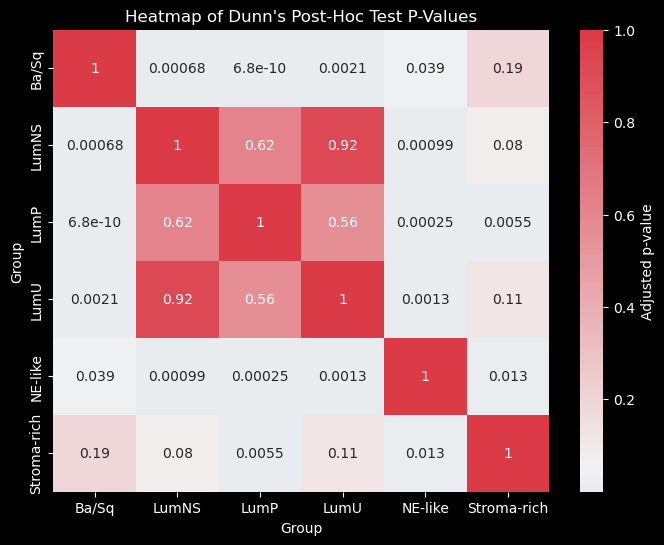

In [81]:
group_sig_test(gene='REL', classifier='consensus', df=dmy_df)

# Selected genes and network metrics

In [ ]:
import pickle as pickle
import os 

ctrls_folder = f'{base_path}/{exp_folder_h42_ctrl}'
folders = next(os.walk(ctrls_folder), (None, None, []))[1]
ctrl_exps = {}
for folder in folders:
    stats_folder = f'{ctrls_folder}/{folder}/Stats/'
    files = next(os.walk(stats_folder), (None, None, []))[2]
    
    ctrl_idx = int(folder.split('hCtrl')[-1])
    ctrl_exps[ctrl_idx] = {}
    for file in files:
        if ('pickle' in file) or (file == 'stats_master.tsv') or (file == '.DS_Store'):
            continue
        dmy_df = pd.read_csv(f"{stats_folder}/{file}", index_col="gene", sep='\t')

        dmy_df['num_tf'] =  int(file.split("_")[-1].split("TF")[0])
        dmy_df['exp'] = file.replace("standard_int", 'std')
        dmy_df['ctrl'] = ctrl_idx
        key_name = file.split(".tsv")[0].replace('.pickle', '').replace(f'standard_int_{folder}', "std")
        ctrl_exps[ctrl_idx][key_name] = dmy_df


In [ ]:
genes = ['RARG', 'PPARG', 'ELF3', 'AHR']
genes = list(diff_markers)
comb_df = pd.DataFrame()
for ctrlExp in ctrl_exps.values():
    for net_stats in ctrlExp.values():
        dmy_df = net_stats.loc[net_stats.index.isin(genes)]
        comb_df = pd.concat([comb_df, dmy_df], axis=0)

# Mark the selected
comb_df['selected_tf'] = "No"
comb_df.loc[comb_df.index.isin(sel_tfs.index), 'selected_tf'] = 'Yes'

In [ ]:
px.box(comb_df.reset_index(), x='gene', y='degree_w', color='selected_tf', points='all')

# Survival analysis

In [ ]:
from lifelines.statistics import multivariate_logrank_test

def prep_survival(df, cs_model="RawKMeans", label="SBM"):
    
    colors_net, color_map = px.colors.qualitative.G10 + px.colors.qualitative.D3, {}
    for idx, val in enumerate(df[cs_model].unique()):
        color_map[val] = colors_net[idx]

    df[cs_model] = df[cs_model].astype(str)
    fig = survival_plot(df.drop(columns=["days_to_last_follow_up", "days_to_death"]), vu_output, classifier=cs_model, color_map=color_map)
    fig = fig.update_layout(title="{}. Survival analysis for {}".format(label, cs_model))

    return fig, color_map

def survival_sig(df, model):
    df = df.reset_index().rename(columns={"index": "Sample"}).copy(deep=True)
    classifier = model

    dmy = df[["days_to_last_follow_up", "days_to_death", classifier]].replace("--", 0).astype(int)
    dmy["last_contact"] = dmy[["days_to_last_follow_up", "days_to_death"]].max(axis=1).div(30)

    labels = list(df[model].unique())
    dmy = dmy[dmy[classifier].isin(labels)]
    print(labels)

    results = multivariate_logrank_test(dmy["last_contact"], dmy[classifier], dmy["days_to_death"])
    display(results.print_summary())
    print("{0:.6f}".format(results.p_value))

# add the survival metadata
tcga_metadata = pd.read_csv(f"{data_base}/tumour/TCGA_metadata.tsv", sep="\t", index_col="Sample")
morp_df['days_to_last_follow_up'] = tcga_metadata['days_to_last_follow_up']
morp_df['days_to_death'] = tcga_metadata['days_to_death']

In [ ]:
cluster_model = 'dendrogram_cut'
fig, dendo_color_map = prep_survival(morp_df, cs_model=cluster_model, label="CS_15")
# save_fig(name="Survival_plot_reward", fig=fig, base_path=figures_path, width=1400, height=600)

fig.update_layout(
    legend=dict(
        orientation="h",
        title="Network subtype",
        yanchor="bottom",
        y=0.9,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    paper_bgcolor="rgba(0,0,0,0)",
    # plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)),
    font=dict(size=16),
    height=700
)
fig.add_annotation(text='Significance p<0.005', x=29, y=0.92, showarrow=False, font=dict(size=18, color="#003366"))
fig.show()
save_fig(name="survival_sel_tfs_cs", fig=fig, base_path=figures_path, width=1000, height=600)


In [ ]:
morp_df[cluster_model] = morp_df[cluster_model].astype(float).astype(int)
survival_sig(morp_df, model=cluster_model)

### Comparing survival

In [ ]:
cluster_model = "dendrogram_cut"
comp_model = 'TCGA408_classifier'

colors_ref = px.colors.qualitative.Pastel2
color_map = {
    "LumP": colors_ref[0],
    "Lum Inf/Ns": colors_ref[1],
    "High IFNG": colors_ref[2],
    "Low IFNG": colors_ref[3],
    "Med IFNG": colors_ref[4],
    "Ne": colors_ref[5],
}

color_map_grey = {label: "grey" for label in morp_df[comp_model].unique()}
color_map = dict(color_map, **color_map_grey)

# choose the subtypes for each to compare if needed
select_labels_1, select_labels_2 = None, None

colors_net = px.colors.qualitative.G10
morp_df[cluster_model] = morp_df[cluster_model].astype(str)
for idx, val in enumerate(morp_df[cluster_model].unique()):
    color_map[val] = colors_net[idx]

fig = survival_comp(
    morp_df.drop(columns=["days_to_last_follow_up", "days_to_death"]),
    vu_output,
    classifier_1=cluster_model,
    classifier_2=comp_model,
    selected_labels_1=select_labels_1,
    selected_labels_2=select_labels_2,
    color_map=color_map,
)
fig = fig.update_layout(title="Survival analysis {}".format("VU + in-situ"))
fig.update_layout(height=900)
# save_fig(name="Survival_plot_reward", fig=fig, base_path=figures_path, width=1400, height=600)

## Apply clustering analysis

In [ ]:
plot_data = tum_tpms_v4.loc[sel_tfs.index]
plot_data = np.log2(plot_data + 1)

gh.find_pcs((plot_data))

In [ ]:
selected_clusters = ["Birch", "RawKMeans", "GaussianMixture", "Ward", "SpectralClustering", "Avg"]

# run experiments
outputs, _, all_metrics, _ = cs.compare_exp(
    plot_data, rob_comp=None, n_clusters=None, selected_clusters=selected_clusters, show_figures=False, show_consensus=True, pca_data=False, n_comp=15,
)
outputs.set_index("Sample", inplace=True)

show_figs=False
if show_figs:
    # Plot the metrics
    fig = cs.display_metrics(all_metrics, f"Cluster metrics for Selected TF", show_individual=False, verbose=True)
    gh.plot_individual_metric(all_metrics, pca=False, offset_db=4)

# Differentially Expressed Analysis

In [83]:
from copy import deepcopy

def toggle_legend(fig: dict, kept_traces =[]):
    for trace in fig['data']:
        if trace.name in kept_traces:
            continue
        trace.visible = 'legendonly'
    return fig

def filter_points_in_rectangle(df, rectangle):
    return df[(df['x'] >= rectangle['x0']) & (df['x'] <= rectangle['x1']) & (df['y'] >= rectangle['y0']) & (df['y'] <= rectangle['y1'])]

f_absCa_p0 = 'sleuth_ABS-Ca_P0_v4_vulcano_labels.tsv'
f_ud_p0 = 'sleuth_UD_P0_v4_vulcano_labels.tsv'
f_absCa_ud = 'sleuth_ABS-Ca_UD_v4_vulcano_labels.tsv'

only_tum = list(set(high_varied_tum) - set(cmn_varied))
only_h  = list(set(high_varied_h) - set(cmn_varied))


#### core-tf are genes that are in the 5% max, min of the the X-axis (AbsCa vs P0) and Y-axis (AbsCa vs UD) comparison 
core_bladder = ['TGIF1', 'PLSCR1', 'AHR', 'SAFB2', 'CIC', 'MBD6', 'POGK', 'ZNF524','SPEN', 'IRF7', 'ELF4', 'ZNF513', 'FBXL19', 'SP110', 'TCF20', 'KMT2A', 'ZNF846', 'ZNF335', 'ZNF276', 'ZNF211', 'HIVEP2', 'DOT1L', 'MAFG', 'ELK4', 'HIVEP1', 'ZNF609', 'LCOR', 'TRERF1', 'NFAT5', 'ZBTB21']
markers_var = {
    '98 TFs': list(sel_tfs.index),
    'tum only': only_tum,
    'non-tum only': only_h,
    "both": cmn_varied,
    'core bladder': core_bladder,
}

# the axis specific are determined to be in 5% within the Axis 
### Determined from dividing the quadrant in boxes and removing the core genes (within 5% of the axis) as well as the one close to the x axis
markers_diff = {
    '98 TFs': list(sel_tfs.index),
    'p0': ['KLF4', 'ETS2', 'PHF1', 'ARID5B', 'EGR1', 'FOXQ1', 'MAFF', 'JUNB', 'MAFK', 'NFIL3', 'SRF', 'RUNX1', 'CASZ1', 'ZBTB10', 'EBF4'],
    'ud': ['SLC2A4RG', 'ZXDB', 'SKI', 'TP63', 'ETS1'],
    'absCa': ['BCL6', 'MSX2', 'ELF3', 'GRHL3', 'REL', 'KLF5', 'ZNF552', 'SATB1', 'DBP', 'ETV7', 'ETV3', 'MECOM', 'REPIN1', 'SP1', 'ZNF586', 'ZBTB4', 'TEAD1', 'ATMIN', 'TMF1', 'SP100', 'FOXJ3', 'MBD1', 'STAT1', 'ANKZF1', 'IRF9', 'STAT2'],
    'absCa_absCa':  ['NFATC4', 'ZNF224', 'ZSCAN16', 'JRK', 'BHLHE41', 'HOXB6'],
    'absCa_ud': ['BNC1', 'MSANTD3', 'HES2'],
    'ud_p0': ['KLF6', 'JUN', 'FOSL1', 'ERF', 'IRF6', 'KLF16'],
    'p0_absCa':  ['NR4A2', 'ATF3', 'OVOL1', 'ZBTB7C', 'FOSL2', 'BCL6', 'MSX2', 'MYCL', 'ZNF750', 'ELF3', 'GRHL3', 'REL', 'KLF5', 'ZNF552', 'SATB1', 'DBP', 'ETV7', 'ETV3', 'MECOM', 'REPIN1', 'SP1', 'ZNF586'],
    'core bladder': core_bladder,
}

In [ ]:
label = 'cmn_varied'
volcano = dea.volcano(f_absCa_ud, base_path=dea_path, known_markers=False, markers=markers_var)
# scatter = sp.draw_scatter(absCa_p0, base_path=dea_path, selected_genes=[], known_markers=True)

volcano = toggle_legend(volcano, kept_traces=markers_var.keys())

volcano.add_annotation(text='UD', x=-4, y=25, showarrow=False, font=dict(size=18, color="#003366"))
volcano.add_annotation(text='AbsCa', x=7, y=25, showarrow=False, font=dict(size=18, color="#003366"))

volcano = volcano.update_layout(height=800)
# volcano.show()

## Pi plots

In [ ]:
if 1:
    # used_markers = markers_diff
    used_markers = markers_var
    
    pi, pi_df = dea.plotPi(f_absCa_p0, f_absCa_ud, base_path=dea_path, known_markers=False, markers=used_markers)
    pi, core_bladder = dea.add_box_core(pi, pi_df, subset=sel_tfs, th=0.05, display=True)
    pi = toggle_legend(pi, kept_traces=used_markers.keys())
    pi.update_layout(
        legend=dict(
            orientation="h",
            # title = '',
            yanchor="bottom",
            xanchor="center",
            y=0.92,
            x=0.3,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=12, color="#003366"),
        ),
        template="ggplot2",
        # paper_bgcolor="rgba(0,0,0,0)",
        xaxis=dict(tickfont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16)),
        xaxis_title='Pi_P0_AbsCa',
        yaxis_title='Pi_AbsCa_UD',
        height=900
    )

    text_color ="#003366"
    # Y axis
    pi.add_annotation(text='ABS-Ca', x=0, y=150, showarrow=False, font=dict(size=18, color=text_color))
    pi.add_annotation(text='UD', x=0, y=-70, showarrow=False, font=dict(size=18, color=text_color))
    # X-axis
    pi.add_annotation(text='P0', x=-220, y=0, showarrow=False, font=dict(size=18, color=text_color))
    pi.add_annotation(text='ABS-Ca', x=65, y=0, showarrow=False, font=dict(size=18, color=text_color))
    pi.update_layout(
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 25
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 25
        )
    )


    display_quadrant = False
    th= 0.05

    # It needs to be ther order of the quadrants
    axis_order = ['AbsCa', 'AbsCa', 'UD', 'P0']
    sel_df = pi_df[pi_df.index.isin(sel_tfs.index)]

    axis_specific, quadrant_df = pd.DataFrame(), pd.DataFrame()
    ### Define the coordinates 
    # -- max/mins
    min_x, max_x = pi_df['x'].min(), pi_df['x'].max()
    min_y, max_y = pi_df['y'].min(), pi_df['y'].max()
    # -- Pi centre
    x_neg, x_pos = min_x*th, max_x*th
    y_neg, y_pos = min_y*th, max_y*th

    ### Define the rectangles
    # -- Axis rectangles 
    rectangles = [
        dict(type='rect', x1=x_pos, y1=max_y, x0=x_neg, y0=0, line=dict(color='black', width=1), layer='below', fillcolor='yellow'),
        dict(type='rect', x1=max_x, y1=y_pos, x0=0, y0=y_neg, line=dict(color='black', width=1),  layer='below'),
        dict(type='rect', x0=x_neg, y0=min_y, x1=x_pos, y1=0, line=dict(color='black', width=1),  layer='below', fillcolor='blue'),
        dict(type='rect', x0=min_x, y0=y_neg, x1=0, y1=y_pos, line=dict(color='black', width=1), layer='below', fillcolor='orange'),
    ]
    # -- Quadrant 
    quadrant = [
        dict(type='rect', x0=x_pos, y0=y_pos, x1=max_x, y1=max_y, line=dict(color='black', width=1), layer='below', fillcolor='blue'),
        dict(type='rect', x1=max_x, y1=y_neg, x0=x_pos, y0=min_y, line=dict(color='black', width=1),  layer='below', fillcolor='purple'),
        dict(type='rect', x1=x_neg, y1=y_neg, x0=min_x, y0=min_y, line=dict(color='black', width=1),  layer='below', fillcolor='red'),
        dict(type='rect', x0=min_x, y0=y_pos, x1=x_pos, y1=max_y, line=dict(color='black', width=1), layer='below', fillcolor='magenta'),
    ]

    ########## Find the points in the quadrant ##########
    for idx, rect in enumerate(rectangles):
        pi.add_shape(**rect)

        inside_df = filter_points_in_rectangle(sel_df, rect)
        inside_df['label'] = axis_order[idx]

        axis_specific = pd.concat([axis_specific, inside_df], axis=0)

    ########## Find the points in the quadrant ##########
    for idx, rect in enumerate(quadrant):
        if display_quadrant:
            pi.add_shape(**rect)

        inside_df = filter_points_in_rectangle(sel_df, rect)
        label = f'{axis_order[idx]}-{axis_order[(idx+1) % (len(axis_order))]}'
        inside_df['label'] = label
        quadrant_df = pd.concat([quadrant_df, inside_df], axis=0)
    pi.show()

In [ ]:
pi

In [ ]:
sel_tfs['varied_label'] = ''
for key, val in markers_var.items():
    if key == '98 TFs':
        continue
    
    if key == 'core bladder':
        sel_tfs.loc[(sel_tfs.index.isin(val)) & (sel_tfs['varied_label'] == ""), 'varied_label'] = key
    else:
        sel_tfs.loc[sel_tfs.index.isin(val), 'varied_label'] = key


sel_tfs['diff_associated'] = ''
for key, val in markers_diff.items():
    sel_tfs.loc[sel_tfs.index.isin(val), 'diff_associated'] = key

# sel_tfs.to_csv(f"{figures_path}/selected_tfs.tsv", sep='\t')

In [110]:
p0 = ['PHF1', 'JUNB', "SRF, CASZ1", 'FOSL2', 'NFIL3', 'RUNX1', 'SRF']
p0_ud = ['ERF', 'IRF6', 'KLF16', 'SLC2A4RG']
ud = ['ZXDB', 'ETS1', 'SKI']
ud_abs = ['MSANTD3']

abs_ca = ['BCL6', 'FOXJ3', 'TMF1', 'ELF3', 'STAT2', 'MECOM', 'ETV7', 'ETV3',
       'SP100', 'NFATC4', 'ZNF586', 'SATB1', 'ZBTB4', 'REPIN1', 'STAT1',
       'ATMIN', 'CASZ1', 'IRF9', 'TEAD1', 'ZSCAN16', 'MBD1', 'SP1', 'ANKZF1',
       'ZNF224', 'KLF5', 'DBP']
# abs_ca = pd.Index(set(sel_tfs[sel_tfs['varied_label'] == ''].index) - set(p0_ud + p0 + ud + ud_abs))

mut_count  tum_median_expression  healthy_median_expression  \
gene                                                                  
ELF3         49.0             516.467020                1434.519008   
JUNB          3.0             248.349863                 271.009715   
KLF5         21.0             160.663601                 403.414207   
STAT1        10.0              91.850454                 147.586097   
TGIF1         4.0             122.278603                 133.417372   
...           ...                    ...                        ...   
NFAT5        13.0               3.649047                  15.113545   
ZBTB21       11.0               3.435088                  10.379879   
ZBTB10        1.0               2.886254                   3.889252   
BNC1          7.0               0.037108                  13.012142   
ZXDB          5.0               2.954496                  10.618395   

        tum_mean_expression  healthy_mean_expression  tum_std_expression  \
gene                                                                       
ELF3             640.581292              1664.910202          567.808783   
JUNB             286.124501               437.743241          181.303215   
KLF5             196.327968               423.927756          158.378786   
STAT1            142.432516               155.719798          140.764415   
TGIF1            133.043308               158.564100           68.719895   
...                     ...                      ...                 ...   
NFAT5              4.739326                16.319613            4.322653   
ZBTB21             3.967440                12.239118            2.319988   
ZBTB10             3.804161                 7.196493            3.285030   
BNC1               3.760191                27.664774            9.283576   
ZXDB               3.303028                12.934440            1.874578   

        healthy_std_expression  tum_var_expression  varied_label  \
gene                                                               
ELF3               1533.937058       322406.813879      p0_absCa   
JUNB                398.875691        32870.855760            p0   
KLF5                252.581784        25083.839989      p0_absCa   
STAT1                99.203676        19814.620595         absCa   
TGIF1                87.264486         4722.423997  core bladder   
...                        ...                 ...           ...   
NFAT5                 8.126043           18.685332  core bladder   
ZBTB21                5.985041            5.382343  core bladder   
ZBTB10                8.219635           10.791424            p0   
BNC1                 37.200816           86.184788      absCa_ud   
ZXDB                  7.000670            3.514041            ud   

       diff_associated  
gene                    
ELF3                    
JUNB                    
KLF5                    
STAT1                   
TGIF1                   
...                ...  
NFAT5                   
ZBTB21                  
ZBTB10                  
BNC1                    
ZXDB                    

[98 rows x 10 columns]

# Linking to the network

## Load experiment sets

In [ ]:
%autoreload 2
exp_folder_h42 = "network_I/healthy42/"

all_h = ExperimentSet("allHealthy42", base_path, exp_folder_h42, tcga_mutations_df, sel_sets = ["5K"], rel_path="../")
all_h.export_to_gephi(save=False)

tf_range = [3, 6, 10]
exps, entropy = GtExp.load_sbm_exps(all_h, name="standard_5K", exp_type="h42_700_degreeCor", tf_range=tf_range)

In [ ]:
%%capture
folders = next(os.walk(base_path + exp_folder_h42_ctrl), (None, None, []))[1]
args, h_ctrls = [], {}
for folder in folders:
    hCtrl_path = "{}/{}/".format(exp_folder_h42_ctrl, folder)
    idx = int(folder.split("hCtrl")[-1])
    h_ctrls[idx] = ExperimentSet("allHealthy42", base_path, hCtrl_path, tcga_mutations_df, sel_sets=["5K"], rel_path="../")
    h_ctrls[idx].export_to_gephi(save=False)

## Exploring gene neighbors

In [ ]:
def get_gene_neigbhors(gt_exp: GtExp, gene_name='BNC1'):

    neighbors = gt_exp.filter_graph(gene=gene_name)
    gt_exp.gt_g.set_vertex_filter(None)

    neighbors_stats, neighbors_df = gt_exp.process_neigbhors(neighbors)
    return neighbors_stats, neighbors_df

In [ ]:
%autoreload 2
import graph_tool.all as gt

sel_gt: GtExp = exps['6']
gt_g: gt.Graph = sel_gt.gt_g

com_df = sel_gt.get_gt_df()
sel_gt.graph_type = 'sbm'
sel_gt.nodes_df['node_idx'] = com_df['node_idx']
sel_gt.nodes_df['max_b'] = com_df['max_b']
sel_gt.nodes_df['ModCon_Rank'] = 0

sel_gt.add_vp(state_idx=0, mut_df=tcga_mutations_df)
sel_gt.add_gt_prop_draw(sel_gt.gt_g, com_df=com_df, tf_list=tf_list)

gt_state = sel_gt.states[0]['state']
pv = sel_gt.states[0]['pv']
gt_g = sel_gt.gt_g


In [ ]:
n_stats, n_df = get_gene_neigbhors(sel_gt, gene_name='BNC1')
gt_g.set_vertex_filter(None)
n_stats

In [ ]:
gene = "AHR"
neigbhors = sel_gt.filter_graph(gene=gene, show_own_com=False)
# sel_gt.gt_g.set_vertex_filter(None)
# stats_neigbhors = sel_gt.process_neigbhors(v_idxs=neigbhors)

In [ ]:


draw_results = gt_state.draw(
    # pos=pos,
    layout="sfdp",
    vertex_shape="pie",
    vertex_pie_fractions=pv,
    inline=False,
    # vertex_color = vp_colors_rank,
    vertex_text=gt_g.vp.prcsd_gene,
    display_props=gt_g.vp.display_prop,
    # subsample_edgesint=int(gt_g.num_edges() * 0.5),
    output_size=(1800, 1800),  # good to visualised in Notebook
    # ######## For mut_count ########
    # vertex_size=gt.prop_to_size((gt_g.vp["sel_com"]), 1, 10, power=0.5),
    vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 10, 30, power=0.5),
    ######## is TF ########
    # vertex_size=gt.prop_to_size(gt_g.vp.is_tf, 10, 30, power=0.5),
    # vertex_font_size=gt.prop_to_size(gt_g.vp.mut_count, 5, 20, power=1),
    ##### edges properties
    # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 1, 4, power=1, log=True),
    # key_press_callback=callback_hsbm,
    # output=f"{figures_path}/v3/{filename}_3.pdf",
    # hide=0,
    update_layout=False,
    nodesfirst=False,
    beta=0.7,
    # chord_scale=5,
    display_props_size=16,
)
